# Introduction
---
This project analyzes the performance of the S&P 500 index over the last five years. As a benchmark representing 500 of the largest U.S. public companies, the S&P 500 is a vital barometer of the American economy. By applying statistical calculations and data visualization, we will quantify its historical trends, volatility, and risk to build a deeper, data-driven understanding of the market's behavior.

We will use Open, High, Low, Close, and volume data to predict the next few days of closing price for the S&P 500 using Long Short-Term Memory neural network.

# Pre-processing/Feature engineering
---

## Imports

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
# data wrangling
import polars as pl
import numpy as np

# data viz
import matplotlib.pyplot as plt
import seaborn as sns

# yfinance api
import yfinance as yf

# for future classes
from dataclasses import dataclass
from typing import List, Union

# neural networks
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

# sklearn for preprocessing
from sklearn.preprocessing import MinMaxScaler

## Configuration

In [87]:
with pl.Config() as cfg:
  cfg.set_tbl_cols(None)
  cfg.set_tbl_rows(500)

## Data Information

In [88]:
# download dataset
symbol = ["^GSPC"]
df = yf.download(symbol, period="5y").reset_index()
df.columns = df.columns.get_level_values(0)

/tmp/ipython-input-491198564.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="5y").reset_index()
[*********************100%***********************]  1 of 1 completed


In [89]:
sp500 = pl.from_pandas(df)

In [90]:
# (rows, columns)
sp500.shape

(1254, 6)

In [91]:
# top 5 rows
sp500.tail()

Date,Close,High,Low,Open,Volume
datetime[ns],f64,f64,f64,f64,i64
2025-08-27 00:00:00,6481.399902,6487.060059,6457.839844,6462.259766,4143680000
2025-08-28 00:00:00,6501.859863,6508.22998,6466.959961,6483.839844,4283760000
2025-08-29 00:00:00,6460.259766,6491.759766,6444.569824,6489.279785,4234840000
2025-09-02 00:00:00,6415.540039,6416.540039,6360.580078,6401.509766,4784000000
2025-09-03 00:00:00,6448.259766,6453.669922,6416.169922,6445.819824,4465360000


In [92]:
# Summary statistics
sp500.describe()

statistic,Date,Close,High,Low,Open,Volume
str,str,f64,f64,f64,f64,f64
"""count""","""1254""",1254.0,1254.0,1254.0,1254.0,1254.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0
"""mean""","""2023-03-04 08:03:26.698564""",4646.826858,4672.149251,4617.940261,4645.739969,4.3638e9
"""std""",null,799.419054,799.148638,798.240673,799.103178,9.5735e8
"""min""","""2020-09-04 00:00:00""",3236.919922,3278.699951,3209.449951,3226.139893,0.0
"""25%""","""2021-12-02 00:00:00""",4045.639893,4075.139893,4013.290039,4041.25,3.7882e9
"""50%""","""2023-03-06 00:00:00""",4431.850098,4453.22998,4403.549805,4429.279785,4.1928e9
"""75%""","""2024-06-03 00:00:00""",5277.509766,5311.649902,5233.850098,5278.240234,4.7486e9
"""max""","""2025-09-03 00:00:00""",6501.859863,6508.22998,6466.959961,6489.279785,9.9765e9


In [93]:
# Null counts
sp500.null_count()

Date,Close,High,Low,Open,Volume
u32,u32,u32,u32,u32,u32
0,0,0,0,0,0


## Feature Engineering

In [94]:
sp500 = sp500.rename(str.lower)

In [95]:
# creating a bunch of features
sp500 = sp500.with_columns(
    sma_50 = pl.col("close").rolling_mean(50), # simple moving average that represents closing prices of a stock averaged over 50 days
    sma_200 = pl.col("close").rolling_mean(200), # simple moving average that represents closing prices of a stock averaged over 200 days
    daily_return = (pl.col("close") / pl.col("close").shift(1) - 1) * 100,
)

sp500 = sp500.with_columns(
    daily_volatility = pl.col("daily_return").std(), # the degree a price fluctuates, where high volatility indicates larger swings and lower volatility is smaller swings
)

RISK_FREE_RATE = 0.00

sp500 = sp500.with_columns(
    annualized_volatility = pl.col("daily_volatility") * (252**0.5), # since there are roughly 252 trading days in a year
    sharpe_ratio = (pl.col("daily_return").mean() - RISK_FREE_RATE) / pl.col("daily_volatility"), # measures risk-adjusted return if we had a risk free rate
    daily_return_skewness = pl.col("daily_return").skew(), # value between -1 to -0.5 or 0.5 to 1 is moderate skewness
    daily_return_kurtosis = pl.col("daily_return").kurtosis(), # statistical measure that indicates the extend to which a distribution's tails differ from a normal distribution.
    var_95 = pl.col("daily_return").quantile(0.05),
    var_99 = pl.col("daily_return").quantile(0.01),
    rolling_vol_60d = pl.col("daily_return").rolling_std(window_size=60) * (252**0.5),
    rsi_14 = pl.col('close').ewm_mean(span=14).alias('rsi_14') # relative strength index measures the magnitude of recent price changes over a 14-period timeframe to evaluate overbought or oversold conditions in a security.
)

In [96]:
sp500.tail()

date,close,high,low,open,volume,sma_50,sma_200,daily_return,daily_volatility,annualized_volatility,sharpe_ratio,daily_return_skewness,daily_return_kurtosis,var_95,var_99,rolling_vol_60d,rsi_14
datetime[ns],f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-27 00:00:00,6481.399902,6487.060059,6457.839844,6462.259766,4143680000,6296.175195,5954.498545,0.239098,1.090708,17.314452,0.051711,0.108901,6.442787,-1.697731,-2.951816,9.642177,6425.17699
2025-08-28 00:00:00,6501.859863,6508.22998,6466.959961,6483.839844,4283760000,6306.557988,5957.142344,0.315672,1.090708,17.314452,0.051711,0.108901,6.442787,-1.697731,-2.951816,9.606793,6435.401373
2025-08-29 00:00:00,6460.259766,6491.759766,6444.569824,6489.279785,4234840000,6316.145781,5959.465942,-0.639818,1.090708,17.314452,0.051711,0.108901,6.442787,-1.697731,-2.951816,9.736795,6438.715826
2025-09-02 00:00:00,6415.540039,6416.540039,6360.580078,6401.509766,4784000000,6325.099785,5961.536892,-0.692228,1.090708,17.314452,0.051711,0.108901,6.442787,-1.697731,-2.951816,9.790178,6435.625721
2025-09-03 00:00:00,6448.259766,6453.669922,6416.169922,6445.819824,4465360000,6333.561582,5963.85824,0.510007,1.090708,17.314452,0.051711,0.108901,6.442787,-1.697731,-2.951816,9.643789,6437.31026


In [97]:
sp500.null_count()

date,close,high,low,open,volume,sma_50,sma_200,daily_return,daily_volatility,annualized_volatility,sharpe_ratio,daily_return_skewness,daily_return_kurtosis,var_95,var_99,rolling_vol_60d,rsi_14
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,49,199,1,0,0,0,0,0,0,0,60,0


In [98]:
df = sp500.drop(["sma_50", "sma_200", "rolling_vol_60d"])
df = df.drop_nulls()

# Visualization
---

In [99]:
!pip install mplfinance

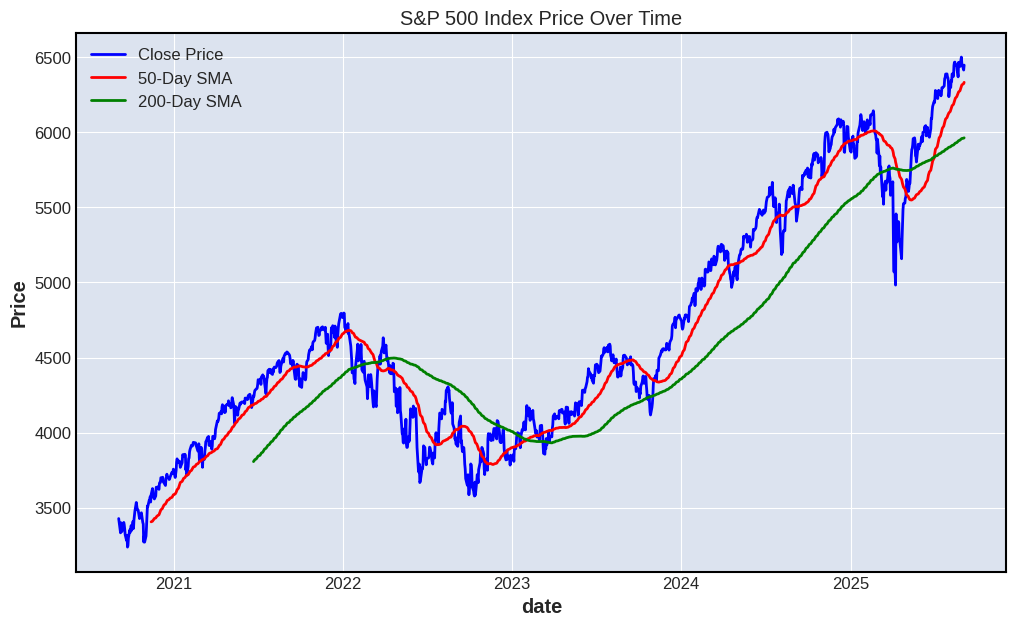

In [100]:
import mplfinance as mpf

plt.figure(figsize=(12, 7))
ax = sns.lineplot(
    data=sp500,
    x="date",
    y="close",
    label="Close Price",
    color="blue"
)

sns.lineplot(
    data=sp500,
    x="date",
    y="sma_50",
    label="50-Day SMA",
    color="red"
)

sns.lineplot(
    data=sp500,
    x="date",
    y="sma_200",
    label="200-Day SMA",
    color="green"
)

plt.title("S&P 500 Index Price Over Time")
plt.xlabel("date")
plt.ylabel("Price")
plt.show()

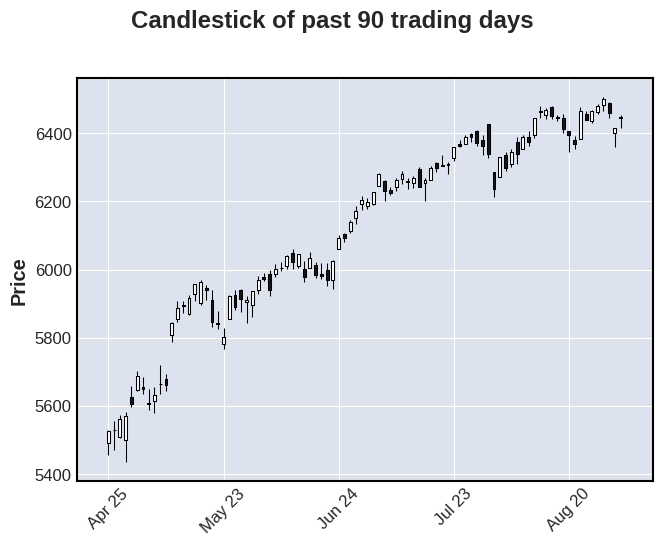

In [101]:
mpf.plot(df.to_pandas().set_index("date").iloc[-90:], type="candle", title="Candlestick of past 90 trading days")

## Preprocessing for model

In [102]:
features = df.columns[1:]
scaler = MinMaxScaler(feature_range=(0, 1)) # scales each feature to given between 0 and 1
scaled_data = scaler.fit_transform(df[features].to_numpy())

In [103]:
prediction_window = 60
X, y = [], []

# use last 60 days of data to predict next day's close
for i in range(prediction_window, len(scaled_data)):
  # X contains the previous 60 days of all features
  X.append(scaled_data[i-prediction_window:i])

  # y contains the next day's closing price
  y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

print(X.shape, y.shape) # (samples, timesteps, features) (samples)

(1193, 60, 14) (1193,)


In [104]:
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)

X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

# Modeling
---

In [105]:
# @title
class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(LSTMModel, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    # define lstm layer
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    # define the fully connected output layer (aka dense layer)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    # init hidden and cell states
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

    # forward propagate lstm
    out, _ = self.lstm(x, (h0, c0))

    # get output from last time step and pass it to linear layer
    out = self.fc(out[:, -1, :])
    return out

In [106]:
# @title
input_size = X_train.shape[2]
hidden_size = 50
num_layers = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
print(model)

LSTMModel(
  (lstm): LSTM(14, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


## Training

In [107]:
print(f"Any NaN in X_train: {torch.isnan(X_train_tensor).any()}")
print(f"Any NaN in y_train: {torch.isnan(y_train_tensor).any()}")

print(f"Any Inf in X_train: {torch.isinf(X_train_tensor).any()}")
print(f"Any Inf in y_train: {torch.isinf(y_train_tensor).any()}")

Any NaN in X_train: False
Any NaN in y_train: False
Any Inf in X_train: False
Any Inf in y_train: False


In [ ]:
# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 25
for epoch in range(num_epochs):
  model.train()

  # forward pass
  outputs = model(X_train_tensor)

  # calculate the loss
  loss = criterion(outputs, y_train_tensor)

  # backward pass and optimization
  optimizer.zero_grad() # clear previous gradeitns
  loss.backward() # compute gradients
  optimizer.step() # update weights

  if (epoch+1) % 5 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [5/25], Loss: 0.192532
Epoch [10/25], Loss: 0.107525
Epoch [15/25], Loss: 0.017759


## Evaluation

In [ ]:
# @title
model.eval()
with torch.no_grad():
  predictions_tensor = model(X_test_tensor)

predictions = predictions_tensor.numpy()

dummy_predictions = np.zeros((len(predictions), len(features)))
dummy_predictions[:, 0] = predictions.ravel()
real_predictions = scaler.inverse_transform(dummy_predictions)[:, 0]

dummy_y_test = np.zeros((len(y_test), len(features)))
dummy_y_test[:, 0] = y_test.ravel()
real_y_test = scaler.inverse_transform(dummy_y_test)[:, 0]

In [ ]:
# plot prediction vs actual
plt.figure(figsize=(14, 7))
plt.plot(real_y_test, color='blue', label='Actual S&P 500 Price')
plt.plot(real_predictions, color='red', label='Predicted S&P 500 Price')
plt.title('S&P 500 Price Prediction')
plt.xlabel('Time (Days)')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

* The model and logic needs some work/optimization

In [ ]:
from pathlib import Path
focus_path = Path("/content/drive/MyDrive/Colab Notebooks/Trading the S&P.ipynb")

In [ ]:
!jupyter nbconvert --to html "{focus_path}"